In [2]:
DEBUG=True

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
import math

In [4]:
data=input_data.read_data_sets("data/MNIST/",one_hot=True) 
data.test.cls = tf.argmax(data.test.labels, axis=1)
#one_hot= Whether to make the labels into a binary array
print("Size of:")
print("Training set \t\t{}".format(len(data.train.labels)))
print("Test set\t\t{}".format(len(data.test.labels)))
print("Validation set\t\t{}".format(len(data.validation.labels)))

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Size of:
Training set 		55000
Test set		10000
Validation set		5000


In [5]:
imgSize=28
imgSizeFlat=imgSize*imgSize
imgShape=(imgSize,imgSize)
noClasses=10
noColorChannels=1
batchSize=100
logs_path = "./logs/03/visualize_graph"
currentTotalIterations=0
sess = tf.Session()

In [6]:
xFlat=tf.placeholder(tf.float32,shape=[None,imgSizeFlat],name='xFlat')
yTrue=tf.placeholder(tf.float32,shape=[None,noClasses],name='yTrue')
yTrueClass=tf.argmax(yTrue,axis=1)

In [7]:
def inputLayer(inputTensor,outputShape=None):
    if outputShape==None:
        outputTensor= inputTensor
    else:
        #x2D=tf.reshape(xFlat,[-1,imgSize,imgSize,noColorChannels])
        inputShape=inputTensor.get_shape()
        outputTensor=tf.reshape(inputTensor,[-1,outputShape[0],outputShape[1],1])
    
    if DEBUG: print("DEBUG: Conv layer added with output tensor shape {}".format(outputTensor.shape))
    return outputTensor

    

In [8]:
def convLayer2D(inputTensor,kernelShape,noKernels,poolingSize=None,activation=None):
    filterLength=kernelShape[0]
    filterHeight=kernelShape[1]
    noFilters=noKernels
    inputShape=inputTensor.get_shape()
    if DEBUG: print("DEBUG: {}".format(inputShape))
    noChannels=int(inputShape[-1])

    shape=[filterLength,filterHeight,noChannels,noFilters]
    if DEBUG: print("DEBUG: Shape of weights {}".format(shape))

    weights=tf.Variable(tf.truncated_normal(shape,stddev=0.5))
    biases=tf.Variable(tf.constant(0.05,shape=[noFilters]))
    outputTensor=tf.nn.conv2d(input=inputTensor,filter=weights,strides=[1,1,1,1],padding='SAME')
    #strides=[img,x,y,colourChannel]
    outputTensor=outputTensor+biases
    
    if poolingSize!=None:
        outputTensor=maxPoolingLayer(outputTensor,poolingSize)
    if activation=='relu':
        outputTensor=relu(outputTensor)
    if DEBUG: print("DEBUG: Conv layer added with output tensor shape {}".format(outputTensor.shape))
    return outputTensor




In [9]:
def maxPoolingLayer(inputTensor,kernelSize):
    return tf.nn.max_pool(value=inputTensor,ksize=[1,kernelSize[0],kernelSize[1],1],strides=[1,kernelSize[0],kernelSize[1],1],padding='SAME')


In [10]:
def relu(inputTensor):    
    return tf.nn.relu(inputTensor)

In [11]:
def flatten(inputTensor):
    shape=inputTensor.get_shape()  # layer_shape == [num_images, img_height, img_width, num_channels]
    noFeatures=int(shape[1]*shape[2]*shape[3])
    outputTensor=tf.reshape(inputTensor,[-1,noFeatures])
    return outputTensor

In [12]:
def fullyConnectedLayer(inputTensor,outputSize):
    inputShape=inputTensor.get_shape()
    shape=[int(inputShape[1]),outputSize]
    weights=tf.Variable(tf.truncated_normal(shape,stddev=0.5))
    biases=tf.Variable(tf.constant(0.05,shape=[outputSize]))
    outputTensor=tf.matmul(inputTensor,weights)+biases
    if DEBUG: print("DEBUG: Added fully connected layer with output shape {}.".format(outputTensor.shape))
    return outputTensor

In [13]:
def buildNetwork(outputTensor,targetTensor):
    crossEntropy=tf.nn.softmax_cross_entropy_with_logits_v2(logits=outputTensor,labels=targetTensor)
    cost=tf.reduce_mean(crossEntropy)
    optimizer=tf.train.AdamOptimizer(learning_rate=0.01).minimize(cost)
    yPredClass=tf.argmax(outputTensor,axis=1)
    correctPrediction=tf.equal(yPredClass,yTrueClass)
    accuracy=tf.reduce_mean(tf.cast(correctPrediction,tf.float32))
    sess.run(tf.global_variables_initializer())
    if DEBUG: print("DEBUG: Completed building network")
    return outputTensor,optimizer,accuracy

def train(optimizer,noIterations,accuracy):
    global currentTotalIterations
    
    for it in range(currentTotalIterations,currentTotalIterations+noIterations):
        #xBatch,yTrueBatch=data.random_batch(batch_size=batchSize)
        #sess.run(optimizer,feed_dict={x:xBatch,y:yTrueBatch})
        
        sess.run(optimizer,feed_dict={xFlat:data.train.images,yTrue:data.train.labels})
        
        if it%20 == 0:
            feedDict2={xFlat:data.train.images,yTrue:data.train.labels}
            acc=sess.run(accuracy,feed_dict=feedDict2)
            print("Training iteration {} : accuracy {}.".format(it+1,acc))
    
    currentTotalIterations+=noIterations

In [14]:
def plotImages(images,clsTarget,clsPred=None):
    #print("DEBUG:{}".format(len(images)))
    assert len(images)==len(clsTarget)==9
    fig,axes=plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.4,wspace=0.4)
    
    for idx,ax in enumerate(axes.flat):
        ax.imshow(images[idx].reshape(imgShape),cmap='binary')
        if clsPred.all()==None:
            ax.set_xlabel("True: {}".format(clsTarget[idx]))
        else:
            ax.set_xlabel("True: {} Predicted: {}".format(np.argmax(clsTarget[idx]),clsPred[idx]))
            
        ax.set_xticks([])
        ax.set_yticks([])

        
def plot9Errors(yTrueClass,yPredClass):
    correct=np.equal(yTrueClass,yPredClass)
    incorrect = (correct == False)
    images = data.test.images[incorrect]
    yPredClass = yPredClass[incorrect]

    # Get the true classes for those images.
    yTrueClass = data.test.labels[incorrect]
    
    # Plot the first 9 images.
    plotImages(images=images[0:9,:],
               clsPred=yPredClass[0:9], 
               clsTarget=yTrueClass[0:9]
                )

def printConfusionMatrix(yTrueTemp,yPredTemp):
    cm=confusion_matrix(y_true=yTrueTemp,y_pred=yPredTemp)
    print(cm)
    plt.matshow(cm)
    plt.colorbar()
    tick_marks = np.arange(noClasses)
    plt.xticks(tick_marks, range(noClasses))
    plt.yticks(tick_marks, range(noClasses))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    
def printTestAccuracy(yPred,accuracy):
    yPredClass=tf.argmax(yPred,axis=1)
    feedDict2={xFlat:data.test.images,yTrue:data.test.labels}

    yTrueClassTemp=sess.run(yTrueClass,{yTrue:data.test.labels})
    yPredClassTemp=sess.run(yPredClass,{xFlat:data.test.images})
    
    acc=sess.run(accuracy,feed_dict=feedDict2)
    
    print("Accuracy on test set: {}".format(acc))
    
    printConfusionMatrix(yTrueClassTemp,yPredClassTemp)
    plot9Errors(yTrueClassTemp,yPredClassTemp)
    

In [15]:
nn=inputLayer(xFlat,[28,28])
nn=convLayer2D(nn,[5,5],16,poolingSize=[2,2],activation='relu')
nn=convLayer2D(nn,[5,5],36,poolingSize=[2,2],activation='relu')
nn=flatten(nn)
nn=fullyConnectedLayer(nn,128)
nn=fullyConnectedLayer(nn,10)
nn,opt,acc=buildNetwork(nn,yTrue)



DEBUG: Conv layer added with output tensor shape (?, 28, 28, 1)
DEBUG: (?, 28, 28, 1)
DEBUG: Shape of weights [5, 5, 1, 16]
DEBUG: Conv layer added with output tensor shape (?, 14, 14, 16)
DEBUG: (?, 14, 14, 16)
DEBUG: Shape of weights [5, 5, 16, 36]
DEBUG: Conv layer added with output tensor shape (?, 7, 7, 36)
DEBUG: Added fully connected layer with output shape (?, 128).
DEBUG: Added fully connected layer with output shape (?, 10).
DEBUG: Completed building network


Accuracy on test set: 0.07240000367164612
[[100   0   1 359   0   3   5  10 502   0]
 [161   6  11 370   0   2 550  27   2   6]
 [175  11  12 567  19   4  43   1 200   0]
 [284   0  12 151   1   3 216   2 341   0]
 [219   0  24 252 106  29  64   5 282   1]
 [184   2   2  98  12   3  85   1 505   0]
 [523   5   0 212  24   8  70  14 102   0]
 [ 66   1  35 119   9  44  12   0 742   0]
 [337   0   1  69  13   4 263  12 275   0]
 [176   0  26  55  65  59  58  18 551   1]]


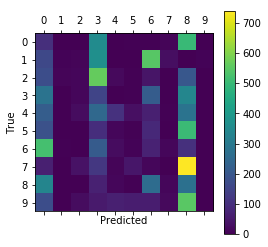

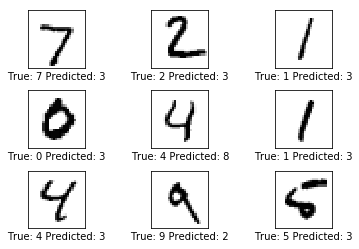

In [16]:
printTestAccuracy(nn,acc)

In [16]:
train(opt,1,acc)

Training iteration 1 : accuracy 0.178327277302742.


In [ ]:
train(opt,10,acc)

In [ ]:
sess.close()